# Assignment 2: Data Preprocessing, Parameter Tuning, Model Evaluation Using SVM, K-NN, K-means, SOM


In [0]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# remove the following statements if you like to see warnings
import warnings
warnings.filterwarnings('ignore')

# [NO MARKS]  Warming Up
Various interesting machine learning datasets can be found at:
- https://archive.ics.uci.edu/ml/index.php

For this task, we have chosen the Heart Disease dataset, available at:
- https://archive.ics.uci.edu/ml/datasets/heart+Disease

**Data Set Information**

- The dataset contains **303 subjects** with **76 attributes**. 
- All the published experiments refer to using a subset of **14 of attributes**. 
- The **goal** field in the dataset refers to **the presence of heart disease** in the patient. 
- It is integer valued from 0 (no presence) to 4 (highest presence). 

**Note:** Since the class number 4 is very sparse (just 13 subjects). We have dropped the subjects belonging to class 4 from the data.

Experiments with the Cleveland dataset have concentrated on---attempting to distinguish **the presence** (values 1, 2, 3, 4) from **the absence** (value 0).

**Attribute Information**

14 attributes are been used: 

1. #3 (age) 
2. #4 (sex) 
3. #9 (cp) 
4. #10 (trestbps) 
5. #12 (chol) 
6. #16 (fbs) 
7. #19 (restecg) 
8. #32 (thalach) 
9. #38 (exang) 
10. #40 (oldpeak) 
11. #41 (slope) 
12. #44 (ca) 
13. #51 (thal) 
14. #58 (num) (the predicted attribute)


### (no marks) Reading the data


In [0]:
# Reading the data-set

df_original = pd.read_csv('processed_cleveland.csv', header=None)
df_original.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
                       'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'prediction']
print('Data-set shape: ',df_original.shape)

df_original.tail(n=10)

Data-set shape:  (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,prediction
293,63.0,1.0,4.0,140.0,187.0,0.0,2.0,144.0,1.0,4.0,1.0,2.0,7.0,2
294,63.0,0.0,4.0,124.0,197.0,0.0,0.0,136.0,1.0,0.0,2.0,0.0,3.0,1
295,41.0,1.0,2.0,120.0,157.0,0.0,0.0,182.0,0.0,0.0,1.0,0.0,3.0,0
296,59.0,1.0,4.0,164.0,176.0,1.0,2.0,90.0,0.0,1.0,2.0,2.0,6.0,3
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0



### (no marks) Removing the missing data
There are many missing data marked by '?' in the dataset. We will use *dropping* as the most straight-forward technique for removing such data-points.

In [0]:
# Removing all subjects from class 4
df = df_original.loc[df_original.prediction != 4]

# Replacing the missing data '?' with NAN values
df.replace('?', np.nan, inplace=True) 
df = df.dropna()
df = df.astype(float)


### (no marks) Splitting the data


In [0]:
# Separating the data and the labels
X = np.asarray(df[df.columns[:-1]]).astype(np.float32)
y = np.asarray(df.prediction)

# Splitting the data into the train and the test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

train_index, test_index = next(sss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
    
print('Training data: \n',X_train)
print('\n')
print('Training labels: \n',y_train)

Training data: 
 [[45.  0.  4. ...  2.  0.  3.]
 [41.  1.  2. ...  2.  0.  6.]
 [42.  1.  4. ...  1.  0.  3.]
 ...
 [67.  1.  4. ...  2.  2.  7.]
 [65.  1.  4. ...  2.  1.  7.]
 [62.  0.  4. ...  1.  0.  3.]]


Training labels: 
 [0. 0. 0. 1. 0. 3. 0. 0. 0. 1. 1. 3. 0. 1. 1. 0. 2. 3. 0. 1. 3. 3. 0. 0.
 0. 2. 0. 0. 3. 0. 0. 0. 3. 1. 2. 0. 0. 3. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 3. 1. 2. 0. 2. 2. 0. 0. 0. 0. 1. 3. 1. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0.
 3. 0. 0. 0. 1. 0. 0. 0. 3. 1. 0. 0. 1. 1. 1. 0. 0. 3. 0. 0. 0. 2. 2. 0.
 0. 0. 0. 0. 0. 3. 0. 2. 2. 2. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 2.
 2. 0. 0. 1. 0. 0. 0. 1. 3. 0. 0. 0. 0. 0. 0. 2. 2. 1. 2. 0. 1. 0. 2. 0.
 3. 1. 0. 0. 0. 3. 0. 0. 0. 2. 2. 0. 2. 1. 0. 0. 0. 3. 3. 0. 0. 0. 0. 1.
 0. 1. 3. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 3. 0. 1. 0. 0. 3. 0. 2. 3. 0. 0.
 0. 0. 2. 0. 1. 1. 0. 0. 3. 0. 2. 1. 0. 2. 2. 0. 0. 0. 1. 0. 0. 0. 3. 1.
 2. 0. 3. 0. 0. 3. 0. 3. 1. 2. 0.]


## [10 marks] Data Exploration

a) (3 marks) Use `pandas` to find the ratio of the presence of disease versus the absence within the different `sex`.

**Note:** `0` is female and `1` is male.

In [0]:
# we have defined a new column which is `true` if there is a presence of disease (i.e., prediction is [1, 2, 3])
df['has_disease'] = df.apply(lambda x: x.prediction in [1, 2, 3], axis=1)
df['no_disease'] = df.apply(lambda x: x.prediction in [0], axis=1)

# use groupby and aggregation
gender_ratio = df.groupby('sex').agg({'has_disease':'sum','no_disease':'sum'})
gender_ratio['ratio']=gender_ratio['has_disease']/gender_ratio['no_disease']
gender_ratio

,has_disease,no_disease,ratio
sex,,,
0.0,23.0,71.0,0.323944
1.0,101.0,89.0,1.134831


b) (7 marks) Do the same thing for age. Split the age groups as follows (left included, right isn't):

1. [29, 49)
2. [49, 69)
3. [69, inf)

And then find the average ratio of prevalence of the heart disease within the each group.

In [0]:
# write your code here

df['age_groups'] = pd.cut(df['age'], bins=[29,49,69,float('inf')], include_lowest=True, right=False)
age_ratio = df.groupby('age_groups').agg({'has_disease':'sum','no_disease':'sum'})
age_ratio['ratio'] = age_ratio['has_disease'] / age_ratio['no_disease']
age_ratio

,has_disease,no_disease,ratio
age_groups,,,
"[29.0, 49.0)",22.0,57.0,0.385965
"[49.0, 69.0)",99.0,95.0,1.042105
"[69.0, inf)",3.0,8.0,0.375000


### (no marks) Utility function

In [0]:
# Do not change the function
# This function is adapted from the sklearn website
# This function let you draw a confusion matrix for your problem

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1 2]
 [3 4]]


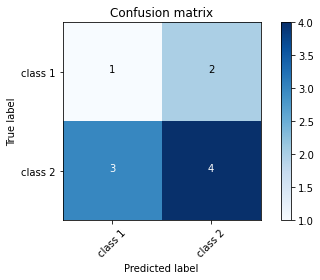

In [0]:
# usage
plot_confusion_matrix(np.array([[1, 2], [3, 4]]), ['class 1', 'class 2'])

# Task 1 [10 marks]

### a) [4 marks] Applying KNN to the data

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90        32
         1.0       0.30      0.27      0.29        11
         2.0       0.50      0.14      0.22         7
         3.0       0.38      0.43      0.40         7

    accuracy                           0.67        57
   macro avg       0.50      0.45      0.45        57
weighted avg       0.64      0.67      0.64        57

Confusion matrix, without normalization
[[31  1  0  0]
 [ 5  3  0  3]
 [ 1  3  1  2]
 [ 0  3  1  3]]


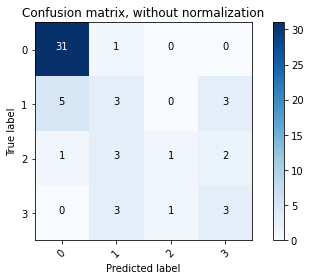

In [0]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.preprocessing import MinMaxScaler

# Task 2
# Add your code in the following part:

# We use min max scaler to normalize the features between [0, 1] 
scaler = MinMaxScaler()

# Add your code here instead of ...
scaler.fit(X_train, y_train)

# Create a knn classifier instance here (If you don't add anything here, your code won't execute!)
knn_clf = KNeighborsClassifier()

# Fit the classifier using the train data (If you don't add anything here, your code won't execute!)
knn_clf.fit(scaler.transform(X_train), y_train)

# Predict the test class labels using the trained classifier (If you don't add anything here, your code won't execute!)
y_pred = knn_clf.predict(scaler.transform(X_test))

# (If you don't add anything here, your code won't execute!) 
print(classification_report(y_test, y_pred))

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3],
                      title='Confusion matrix, without normalization')

### b) [3 marks] Between $K=3$ and $k=5$ which one gives more  accuracy ?

In [0]:
from sklearn.metrics import accuracy_score

# write your code here and populate `y_pred_k5` and `y_pred_k3`

knn_clf_k5 = KNeighborsClassifier(n_neighbors=5)
knn_clf_k5.fit(scaler.transform(X_train), y_train)
y_pred_k5 = knn_clf_k5.predict(scaler.transform(X_test))

knn_clf_k3 = KNeighborsClassifier(n_neighbors=3)
knn_clf_k3.fit(scaler.transform(X_train), y_train)
y_pred_k3 = knn_clf_k3.predict(scaler.transform(X_test))

print(accuracy_score(y_test, y_pred_k5), accuracy_score(y_test, y_pred_k3))

print('k5 is more accurate')

0.6666666666666666 0.5964912280701754
k5 is more accurate


### c) [3 marks] Between $\ell_1$, $\ell_2$, and $cosine$ similarity which one is better in term of accuracy?

In [0]:
# write your code here to experiment with different distance metrics
# use argument `metric` to change to a different distance by default it is euclidean distance 

knn_clf_l1 = KNeighborsClassifier(metric='l1')
knn_clf_l1.fit(scaler.transform(X_train), y_train)
y_pred_l1 = knn_clf_l1.predict(scaler.transform(X_test))

knn_clf_l2 = KNeighborsClassifier(metric='l2')
knn_clf_l2.fit(scaler.transform(X_train), y_train)
y_pred_l2 = knn_clf_l2.predict(scaler.transform(X_test))

knn_clf_cosine = KNeighborsClassifier(metric='cosine')
knn_clf_cosine.fit(scaler.transform(X_train), y_train)
y_pred_cosine = knn_clf_cosine.predict(scaler.transform(X_test))

print(accuracy_score(y_test, y_pred_l1), accuracy_score(y_test, y_pred_l2), accuracy_score(y_test, y_pred_cosine))

print('l2 and cosine are the same value and more accurate')

0.6491228070175439 0.6666666666666666 0.6666666666666666
l2 and cosine are the same value and more accurate


# Task 2 [10 marks]

### Understanding the pipelining architecture of `Sklearn`

In the code above, you had to call `scaler` for every prediction by a model. This can be avoided by using a `pipeline` mechanism within sklearn. Look at the code below:

1. We create a data scaler (can be any sclaer with fit and transform functions).
2. We create SVC object (again with fit and transform functions).
3. Then we create a pipeline: `data --> scaler --> svc --> fit`.
4. The same transformation is also applied during the prediction phase.

We further use a `GridSearchCV` for the SVC's parameters tuning.

In [0]:
# Task 2

# Creating a SVM classifier instance
svc = SVC()

# Add a scaler here (If you don't add anything here, your code won't execute!)
data_scaler = StandardScaler()

# Update the pipeline by adding the scaler from the previous line
model = make_pipeline(data_scaler,svc)
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)
%time grid.fit(X_train, y_train)
print(grid.best_estimator_)

CPU times: user 364 ms, sys: 3.08 ms, total: 367 ms
Wall time: 373 ms
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=50, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [0]:
# Selecting the best estimator after the parameter search
model = grid.best_estimator_

In [0]:
# Predicting the test labels
y_pred = model.predict(X_test)

In [0]:
# Printing the classification report
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86        32
         1.0       0.43      0.27      0.33        11
         2.0       0.33      0.29      0.31         7
         3.0       0.25      0.14      0.18         7

    accuracy                           0.65        57
   macro avg       0.45      0.42      0.42        57
weighted avg       0.59      0.65      0.61        57



Confusion matrix, without normalization
[[31  0  1  0]
 [ 7  3  1  0]
 [ 1  1  2  3]
 [ 1  3  2  1]]


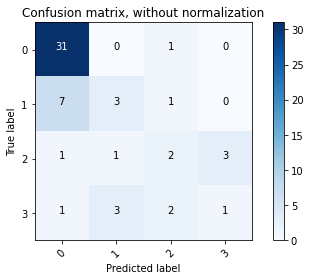

In [0]:
# Computing the confusion matrix for the test data
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using the previous function
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3],
                      title='Confusion matrix, without normalization')

# Task 3 [20 marks]

### How to handle the missing data

More information can be found here:
(https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)

a) [4 scores] Name two numeric methods for dealing with the missing data (except dropping):
    
    Write the answer here:
    
    1- linear interpolate missing data using interpolate() 
    
    2- fill in missing values using fillna()
    

b) [6 scores] Apply the methods that you mentioned in part (a) to the `df_with_missing_data` dataframe:

In [0]:
# Task 3 part (b)
# Add your code here (If you don't add anything here, your code won't execute!)

df_with_missing_data = pd.read_csv('/content/processed_cleveland.csv', header=None)
df_with_missing_data.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
                                'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'prediction']

df_with_missing_data.replace('?', np.nan, inplace=True)

df_1 = df_with_missing_data.astype(np.float32).interpolate()
df_2 = df_with_missing_data.fillna(0)


c) [10 scores] Apply the steps described in *Task 2* on `df_1` and `df_2` and show the results using `classification_report` and `plot_confusion_matrix`.

Results for df_1
CPU times: user 419 ms, sys: 575 µs, total: 420 ms
Wall time: 421 ms
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=50, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.87        33
         1.0       0.15      0.18      0.17        11
         2.0       0.20      0.14      0.17         7
         3.0       0.20      0.14      0.17         7
         4.0       0.00      0.00      0.00         3

    accuracy                           0.57        61
   macro avg  

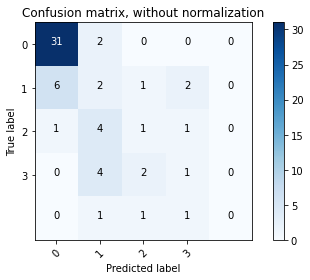

Results for df_2
CPU times: user 391 ms, sys: 3.71 ms, total: 395 ms
Wall time: 395 ms
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=50, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
              precision    recall  f1-score   support

           0       0.82      0.94      0.87        33
           1       0.14      0.18      0.16        11
           2       0.20      0.14      0.17         7
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3

    accuracy                           0.56        61
   macro avg 

<function matplotlib.pyplot.show>

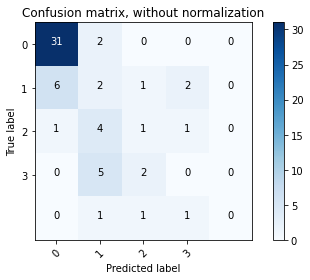

In [0]:
# Task 3 part (c)
# Add your code here

def results(df):
  # Separating the data and the labels
  X = np.asarray(df[df.columns[:-1]]).astype(np.float32)
  y = np.asarray(df.prediction)

  # Splitting the data into the train and the test sets
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
  sss.get_n_splits(X, y)

  train_index, test_index = next(sss.split(X, y))
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # Creating a SVM classifier instance
  svc = SVC()

  # Add a scaler here (If you don't add anything here, your code won't execute!)
  data_scaler = StandardScaler()

  # Update the pipeline by adding the scaler from the previous line
  model = make_pipeline(data_scaler,svc)
  param_grid = {'svc__C': [1, 5, 10, 50],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

  grid = GridSearchCV(model, param_grid)
  %time grid.fit(X_train, y_train)
  print(grid.best_estimator_)

  # Selecting the best estimator after the parameter search
  model = grid.best_estimator_

  # Predicting the test labels
  y_pred = model.predict(X_test)

  # Printing the classification report
  print(classification_report(y_pred=y_pred,y_true=y_test))

  # Computing the confusion matrix for the test data
  cnf_matrix = confusion_matrix(y_test, y_pred)

  # Plotting the confusion matrix using the previous function
  plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3],
                        title='Confusion matrix, without normalization')
  
print('Results for df_1')
results(df_1)
plt.show()

print('Results for df_2')
results(df_2)
plt.show

# Task 4 [10 marks]

### Model Evaluation

For the given confusion matrix, answer the following questions.

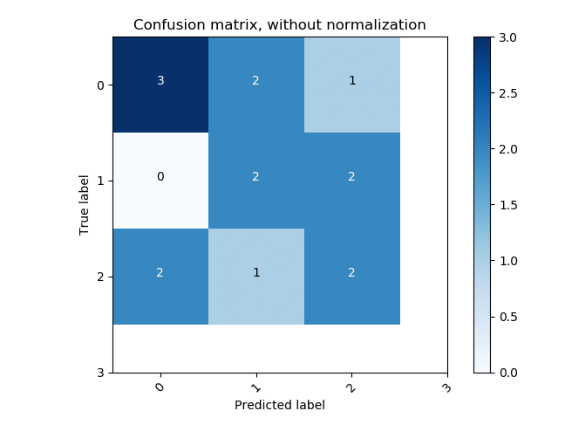

In [0]:
I = plt.imread('foo.png')
fig = plt.figure(figsize= (10,10))
plt.imshow(I)
plt.axis('off')
plt.show()

#### Calculate the following parameters (Use macro-average definition)

You can find all these definitions on https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
 and https://en.wikipedia.org/wiki/Confusion_matrix
 
 Write your answer in front of each parameter:

1- [1 score] total number of instances = 15

2- [1 score] number of classes = 3

3- [1 score] True positive (TP) = (3+2+2)/3 = 2.3333

4- [1 score] True negative (TN) = (7+8+7)/3 = 7.3333

5- [1 score] False positive (FP) = (2+3+3)/3 = 2.6667

6- [1 score] False negative (FN) = (3+2+3)/3 = 2.6667

7- [1 score] Sensitivity, recall, hit rate, or true positive rate (TPR) <br>
class 0: 3/(3+3) = 0.5 <br>
class 1: 2/(2+2) = 0.5 <br>
class 2: 2/(2+3) = 0.4 <br>
TPR = (0.5+0.5+0.4)/3 = 0.4667

8- [1 score] Specificity, selectivity or true negative rate (TNR) <br>
class 0: 7/(7+2) = 0.7777 <br>
class 1: 8/(8+3) = 0.7272 <br>
class 2: 7/(7+3) = 0.7 <br>
TNR = (0.778+0.727+0.7)/3 = 0.7350

9- [2 scores] F1-Score <br>
F1 = 2*TP / (2*TP + FP + FN) <br>
F1 = 2*2.3333 / (2*2.3333 + 2.6667 + 2.6667) <br>
F1 = 0.4667


# Task 5 [20 marks]

## kmeans objective function
The objective function for kmeans clustering is as follows: 

$$E(S,\mu)= \sum_{k=1}^K \sum_{p\in S^k}\|f_p-\mu_k \|^2 \tag{1}$$

where $S^k$ is set of data points in $k_{th}$ cluster and $\mu_k$ is mean of data points in $k_{th}$ cluster. If we replace the fromula for calculating $\mu_k$ (sample mean):$\mu_k=\frac{1}{|S^k|}\sum_{p\in S^k}^K f_p$ $\enspace$ ($|S^k|$ is number of data points in $k_{th}$ cluster) in equation (1) the non-parametric version of kmeans objective function can be obtained and that is:


$$E(S)=\sum_{k=1}^K \frac{\sum_{pq\in S^k}\|f_p-f_q\|^2}{2\;|S^k|} \tag{2}$$

where $f_p$ and $f_q$ are $p_{th}$ and $q_{th}$ data points in $S^k$.

### a) Show that this non-parametric objective function can be written as:

$$E(S)=\sum_{k=1}^K  |S^k|.    var(S^k)$$ where $var(S^k)$ is sample variance of data points in $S^k$.

### b) Show the following equivalance for the nonparametric formulation of kmeans objective function:

$$ E(S)= \sum_{k=1}^K \frac{\sum_{pq\in S^k}\|f_p-f_q\|^2}{2\;|S^k|} \;\;=\;\; const - \sum_{k=1}^K \frac{\sum_{pq\in S^k} \langle f_p,f_q\rangle}{|S^k|}$$

Where $const$ is a constant and $\langle f_p,f_q\rangle$ is dot product of $f_p$ and $f_q$.

# Solution

## Part A

$$E(S,\mu)= \sum_{k=1}^K \sum_{p\in S^k}\|f_p-\mu_k \|^2$$
$$E(S,\mu)= \sum_{k=1}^K \sum_{p\in S^k}\ \frac{|f_p-\mu_k \|^2}{|S^k|} |S^k|$$
$$E(S,\mu)= \sum_{k=1}^K |S^k|.var(S^k)$$

## Part B


$$E(S)=\sum_{k=1}^K \frac{\sum_{pq\in S^k}\|f_p-f_q\|^2}{2\;|S^k|} $$
$$E(S)=\sum_{k=1}^K \frac{\sum_{pq\in S^k}[\|f_p\|^2-2\langle f_p, f_q\rangle+\|f_q\|^2]}{2\;|S^k|} $$
$$E(S)=\sum_{k=1}^K \frac{\sum_{pq\in S^k}\|f_p\|^2-2\sum_{pq\in S^k}\langle f_p, f_q\rangle+\sum_{pq\in S^k}\|f_q\|^2}{2\;|S^k|} $$
$$E(S)=\sum_{k=1}^K \frac{const-2\sum_{pq\in S^k}\langle f_p, f_q\rangle+const}{2\;|S^k|} $$
$$E(S)= \frac{\sum_{k=1}^Kconst-2\sum_{k=1}^K\sum_{pq\in S^k}\langle f_p, f_q\rangle+\sum_{k=1}^Kconst}{2\;|S^k|} $$
$$E(S)= const+\frac{-2\sum_{k=1}^K\sum_{pq\in S^k}\langle f_p, f_q\rangle}{2\;|S^k|} $$
$$E(S)= const - \sum_{k=1}^K \frac{\sum_{pq\in S^k} \langle f_p,f_q\rangle}{|S^k|}$$


# Task 6 [10 marks]

## color quantization using kmeans 
### step 1 image to data matrix

Write a function that takes an image and return a numpy array where number of rows are equal to number of pixels and number columns is equal to 3 representing $[R,G,B]$ 

In [0]:
def image_to_data(image,weightXY=.1):
    
    # write your code here
    row,col,dim=image.shape
    data=[]
    for i in range(0,row):
      for j in range(0,col):
        data.append(image[i,j])

    data_matrix=np.asarray(data,dtype=np.uint8)

    return data_matrix

[link text](https://)### step 2 use elbow method and find number of clusters
In the following a sample image is provided in image variable. Use image_to_data function that you wrote in the step 1 and calculate data_matrix. Then write a peace of code that implements elbow method and apply that on data_matrix.
Find optimal value of number of clusters data_matrix and put this value in number_of_custers.  

In [0]:
# loading sample image
from skimage.io import imread
from sklearn.datasets import load_sample_image
from scipy.spatial.distance import cdist
image = load_sample_image('flower.jpg')

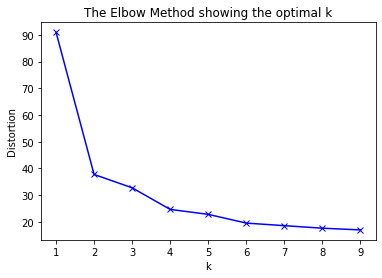

In [0]:
# write your code for elbow method here

matrix=image_to_data(image,weightXY=0.1)

plt.plot()
colour=['b','g','r']
marker=['o','v','s']

distortions=[]
K=range(1,10)
for k in K:
  kmeanModel=KMeans(n_clusters=k).fit(matrix)
  kmeanModel.fit(matrix)
  distortions.append(sum(np.min(cdist(matrix,kmeanModel.cluster_centers_,'euclidean'),axis=1))/matrix.shape[0])

plt.plot(K,distortions,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#store optimal value for number of clusters here in number_of_custers
number_of_custers=3

### step 3 apply kmeans on data matrix
The data_matrix that you calculated in step 2, is a three dimensional representation of the image. So the squared error between RGB feture $F_p=[R_p,G_p,B_p]$ at any pixel $p$ and any given cluster mean $m=[R_m,G_m,B_m]$ is 
#### $$||F_p - m||^2 = (R_p - R_m)^2 + (G_p - G_m)^2 + (B_p - B_m)^2.$$

Use sklearn to apply kmeans on data_matrix. Please use the optimal value for number of clusters that you found in step 2.

After applying kmeans, for each data point (row in data_matrix) you have a 3 vector which is the closest cluster center to that data point or equally center of the cluster this data point belongs to. 

For each data point, find the closest cluster center which is a 3 vector and bring back these values in the image shape and visualize that as an iamge using plt.imshow().



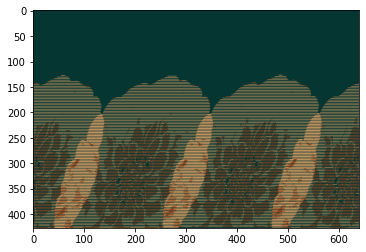

In [0]:
# write your code here

from sklearn.cluster import KMeans

"""
# generate even indices to pick training data
train_idx=np.arange(0,500,2)
train_X=matrix[train_idx,:]


# generate odd indices to pick test data
test_idx=np.arange(1,500,2)
test_X=matrix[test_idx,:]
"""
#define k-means model
model=KMeans(n_clusters=3)

#fit the model
model.fit(matrix)

#predict
cluster_matrix=model.predict(matrix)

#centroids
centers=model.cluster_centers_

row,col,dim=image.shape
new_image=np.zeros((row,col,dim))

for i in range(0,row):
  for j in range(0,col):
    new_image[i,j]=centers[cluster_matrix[i*row +j]]

plt.imshow(new_image.astype('uint8'))

# Task 7 [10 marks]
## SOM
Use minisom package, create a latice with size of (40,40) and map train_data (which consits of 15 colors) to this lattice. 
put the earning_rate=0.5, sigma=4, and 1000 iterations for trainig your model.

In [0]:
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.5-cp36-none-any.whl size=8474 sha256=000db8cf93e53b84f003a839ddc3252f0319aef36c592711dc3aab03ddcf29b1
  Stored in directory: /root/.cache/pip/wheels/39/5b/16/cc9402ffc58cafb1da6997e5c94b1bde65e8cb214907879fd4
Successfully built minisom


In [0]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload

#Training inputs for RGBcolors
train_data = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

from minisom import MiniSom   
# define your model here

som = MiniSom(40,40,3,sigma=4,learning_rate=0.5)  

# train your model:

som.train_random(train_data,1000)

# after training the som, extract the weights of neurons and store them in variable som_weights
som_weights=som.get_weights().copy()

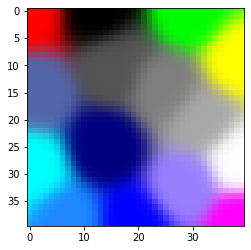

In [0]:
#Run this to visualize the result
plt.imshow(abs(som_weights), interpolation='none')

change the value of sigma to 1 and get the results again. Explain the difference you see.

Number of neurons increases